# Extracción de caracteristicas proyecto:
# Clasificación de supernovas de ALeRCE - ZTF
### Por Joaquin Zepeda y Benjamin Irarrazabal - Tutor: Pablo Montero

#Bloque Inicial
Ejecutar una vez y luego reiniciar el entorno de ejecución

In [ ]:
# pyarrow might be needed to read the data
!python -m pip install Cython
!python -m pip install -e git+https://git@github.com/alercebroker/turbo-fats#egg=turbofats
!python -m pip install -e git+https://git@github.com/alercebroker/mhps#egg=mhps
!python -m pip install -e git+https://git@github.com/alercebroker/P4J#egg=P4J
!python -m pip install pyarrow
!python -m pip install -e git+https://git@github.com/alercebroker/lc_classifier#egg=lc_classifier

# Bloques Principales
Luego de realizar el paso previo, se pueden ejecutar uno a uno los siguientes bloques

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
# Se imprime la version de Tensorflow
print('Tensorflow version', tf.__version__)


Tensorflow version 2.4.0


# Importamos los extractores de caracteristicas

In [2]:
from lc_classifier.features import SupernovaeDetectionFeatureExtractor, SNParametricModelExtractor, IQRExtractor,MHPSExtractor

# Leyendo los datos
La idea es seleccionar los dos archivos CSV que contienen los datos: 

1- detections_SNe_v7.0.1.csv

2- dfcrossmatches_prioritized_v7.0.1.csv

In [3]:
import pandas as pd
url_det='https://raw.githubusercontent.com/joaquinzepeda/Datos/main/datos%20supernovas/detections_SNe_v7.0.1.csv'
url_dfcross='https://raw.githubusercontent.com/joaquinzepeda/Datos/main/datos%20supernovas/dfcrossmatches_prioritized_v7.0.1.csv'
detections = pd.read_csv(url_det, index_col=None)
dfcrossmatches = pd.read_csv(url_dfcross, index_col=None)

# Union de tablas
Se realiza un Join con el fin de tener además de los nombres de los objetos, la clase a la cual pertenece, tendremos algunas columnas extras las cuales serán eliminadas más tarde

In [4]:
Conjunto = pd.merge(detections, dfcrossmatches, left_on='objectId', right_on='oid')

In [5]:
Conjunto.head()

,Unnamed: 0,objectId,fid,isdiffpos,sigmapsf,field,fwhm,dec_x,magpsf,rcid,...,has_stamp,oid,classALeRCE,ra_y,dec_y,period,source,id_source,class_source,separation_arcsec
0,0,ZTF18aahvndq,1,1.0,0.028791,626,3.59,27.008621,15.385100,34,...,True,ZTF18aahvndq,SNIa,198.722653,27.008637,NaN,TNS,SN 2020jhf,SN Ia,0.103069
1,1,ZTF18aahvndq,1,1.0,0.031231,626,2.57,27.008635,15.712121,34,...,True,ZTF18aahvndq,SNIa,198.722653,27.008637,NaN,TNS,SN 2020jhf,SN Ia,0.103069
2,2,ZTF18aahvndq,1,1.0,0.032161,626,1.98,27.008647,16.072975,34,...,True,ZTF18aahvndq,SNIa,198.722653,27.008637,NaN,TNS,SN 2020jhf,SN Ia,0.103069
3,3,ZTF18aahvndq,1,1.0,0.049931,626,2.75,27.008624,17.708502,34,...,True,ZTF18aahvndq,SNIa,198.722653,27.008637,NaN,TNS,SN 2020jhf,SN Ia,0.103069
4,4,ZTF18aahvndq,1,1.0,0.028520,626,3.13,27.008636,15.617474,34,...,True,ZTF18aahvndq,SNIa,198.722653,27.008637,NaN,TNS,SN 2020jhf,SN Ia,0.103069


In [6]:
# Le hacemos un slicing al conjunto:
slice_cjto = Conjunto[['classALeRCE','oid','objectId','isdiffpos','magpsf','mjd','magpsf_corr','sigmapsf','sigmapsf_corr','fid']]
slice_cjto.head() # Printeamos las primeras filas del conjunto para observar que se hayan tomado bien los datos

,classALeRCE,oid,objectId,isdiffpos,magpsf,mjd,magpsf_corr,sigmapsf,sigmapsf_corr,fid
0,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,15.385100,58991.302095,NaN,0.028791,NaN,1
1,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,15.712121,59000.260914,NaN,0.031231,NaN,1
2,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,16.072975,59004.192674,NaN,0.032161,NaN,1
3,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,17.708502,59021.227604,NaN,0.049931,NaN,1
4,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,15.617474,58986.223646,NaN,0.028520,NaN,1


# Limpieza de datos: 
Se quitan los registros que se detecten como outliers, estos corresponderian a los que se alejan a más de 3 desviaciones estandar del promedio.

In [7]:
from scipy import stats
clean_data = slice_cjto[((np.abs(stats.zscore(slice_cjto['magpsf']))<3)&(slice_cjto['sigmapsf']<1))]

In [8]:
clean_data.head()

,classALeRCE,oid,objectId,isdiffpos,magpsf,mjd,magpsf_corr,sigmapsf,sigmapsf_corr,fid
2,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,16.072975,59004.192674,NaN,0.032161,NaN,1
3,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,17.708502,59021.227604,NaN,0.049931,NaN,1
6,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,16.626165,59009.258669,NaN,0.044748,NaN,1
8,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,18.192377,59036.198090,NaN,0.078094,NaN,1
9,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,18.481302,59045.238090,NaN,0.083104,NaN,1


# Se arreglan los NaN que aparecen en magpsf_corr y sigmapsf_corr copiando el valor que tienen en sus versiones no corregidas.

In [9]:
n = len(clean_data)
copy_cleandata = clean_data.copy()

for i in range(0,n):
  if pd.isna(clean_data.iloc[i,8]) == True:
    copy_cleandata.iloc[i,8] = copy_cleandata.iloc[i,7]
  else:
    pass
for i in range(0,n):
  if pd.isna(clean_data.iloc[i,6]) == True:
    copy_cleandata.iloc[i,6] = copy_cleandata.iloc[i,4]
  else:
    pass

In [14]:
copy_cleandata.head()

,classALeRCE,oid,objectId,isdiffpos,magpsf,mjd,magpsf_corr,sigmapsf,sigmapsf_corr,fid
2,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,16.072975,59004.192674,16.072975,0.032161,0.032161,1
3,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,17.708502,59021.227604,17.708502,0.049931,0.049931,1
6,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,16.626165,59009.258669,16.626165,0.044748,0.044748,1
8,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,18.192377,59036.198090,18.192377,0.078094,0.078094,1
9,SNIa,ZTF18aahvndq,ZTF18aahvndq,1.0,18.481302,59045.238090,18.481302,0.083104,0.083104,1


# Calculamos la cantidad de supernovas que hay en la base de datos

In [11]:
# tomamos un subslice de los datos tomando solo la columna del Id con la de la clase:
subslice = clean_data[['objectId','classALeRCE']]
# Ahora, a este subslice, le eliminamos los "duplicados" de cada curva para poder obtener la cantidad de supernovas que tenemos
subslice_sinduplicados = subslice.drop_duplicates(subset=['objectId'])
# Y ahora que ya tenemos esto, podemos calcular la cantidad de supernovas real que hay, es decir, tomando solo 1 muestra para c/u
subslice_sinduplicados.groupby('classALeRCE').count()


,objectId
classALeRCE,
SLSN,34
SNII,330
SNIIb,16
SNIIn,42
SNIa,1540
SNIbc,106


<AxesSubplot:xlabel='classALeRCE'>

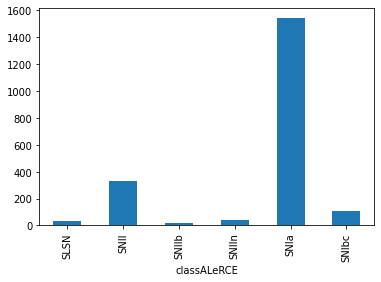

In [12]:
group_cleandata = subslice_sinduplicados.groupby('classALeRCE')['classALeRCE'].count()
group_cleandata.plot(kind='bar')

# Se le cambia el nombre a los datos solo por conveniencia, los datos a utilizar ya filtrados corresponden a "Datos_Final"

In [2]:
# Ahora, tomaremos un ejemplo de cada supernova y graficaremos su curva de luz.
Datos_Final = copy_cleandata #Las muestras con los NaN reemplazados y sin outliers

NameError: name 'copy_cleandata' is not defined

NameError: name 'Datos_Final' is not defined

#Se grafica un ejemplo de curva de luz por cada tipo de supernova

In [14]:
# Ahora comenzamos a tomar datos para las curvas de luz, como son 6 tipos de curvas de luz haremos 1 ejemplo de cada una (ie, 6 curvas)
import matplotlib.pyplot as plt
Curva_SNIa = Datos_Final.loc[Datos_Final.loc[:,'oid']=='ZTF20aaxxcms'] # SNIa
Curva_SNII = Datos_Final.loc[Datos_Final.loc[:,'oid']=='ZTF19abhduuo'] # SNII
Curva_SLSN = Datos_Final.loc[Datos_Final.loc[:,'oid']=='ZTF19aalbrgu'] # SLSN
Curva_SNIIb = Datos_Final.loc[Datos_Final.loc[:,'oid']=='ZTF19aaejtof'] # SNIIb
Curva_SNIIn = Datos_Final.loc[Datos_Final.loc[:,'oid']=='ZTF19abgndlf'] # SNIIn
Curva_SNIbc = Datos_Final.loc[Datos_Final.loc[:,'oid']=='ZTF19abqwtfu'] # SNIbc


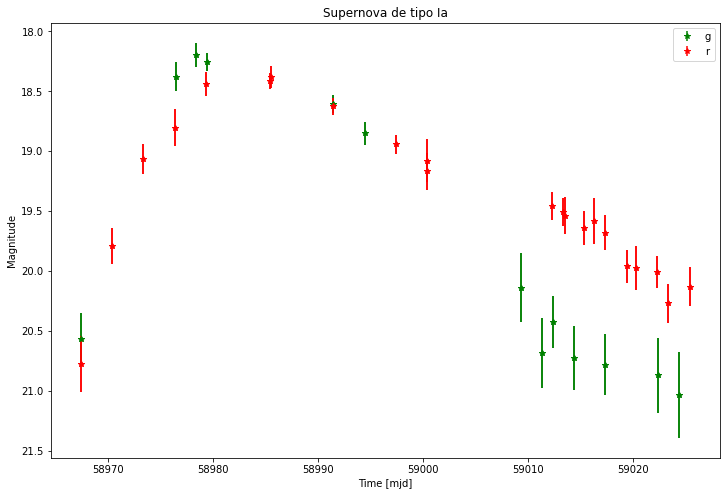

In [15]:
# GRAFICAMOS LA CURVA PARA LA SUPERNOVA TIPO Ia
lc_g_SNIa = Curva_SNIa[Curva_SNIa.fid == 1]
lc_r_SNIa = Curva_SNIa[Curva_SNIa.fid == 2]
fig = plt.figure(figsize=(12, 8))
fig.set_facecolor('white')

plt.errorbar(lc_g_SNIa['mjd'], lc_g_SNIa['magpsf_corr'], yerr=lc_g_SNIa['sigmapsf_corr'], fmt='*g', label='g')
plt.errorbar(lc_r_SNIa['mjd'], lc_r_SNIa['magpsf_corr'], yerr=lc_r_SNIa['sigmapsf_corr'], fmt='*r', label='r')
plt.xlabel('Time [mjd]')
plt.ylabel('Magnitude')
plt.title('Supernova de tipo Ia')
plt.legend()
plt.gca().invert_yaxis()

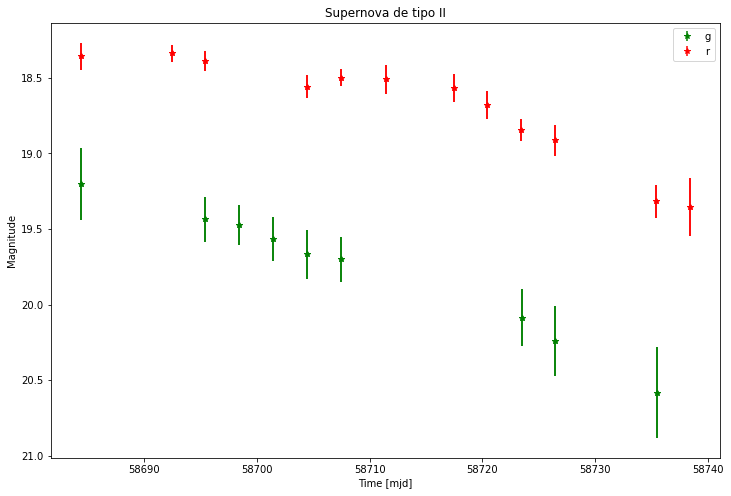

In [16]:
# GRAFICAMOS LA CURVA PARA LA SUPERNOVA DE TIPO II
lc_g_SNII = Curva_SNII[Curva_SNII.fid == 1]
lc_r_SNII = Curva_SNII[Curva_SNII.fid == 2]
fig = plt.figure(figsize=(12, 8))
fig.set_facecolor('white')

plt.errorbar(lc_g_SNII['mjd'], lc_g_SNII['magpsf_corr'], yerr=lc_g_SNII['sigmapsf_corr'], fmt='*g', label='g')
plt.errorbar(lc_r_SNII['mjd'], lc_r_SNII['magpsf_corr'], yerr=lc_r_SNII['sigmapsf_corr'], fmt='*r', label='r')
plt.xlabel('Time [mjd]')
plt.ylabel('Magnitude')
plt.title('Supernova de tipo II')
plt.legend()
plt.gca().invert_yaxis()

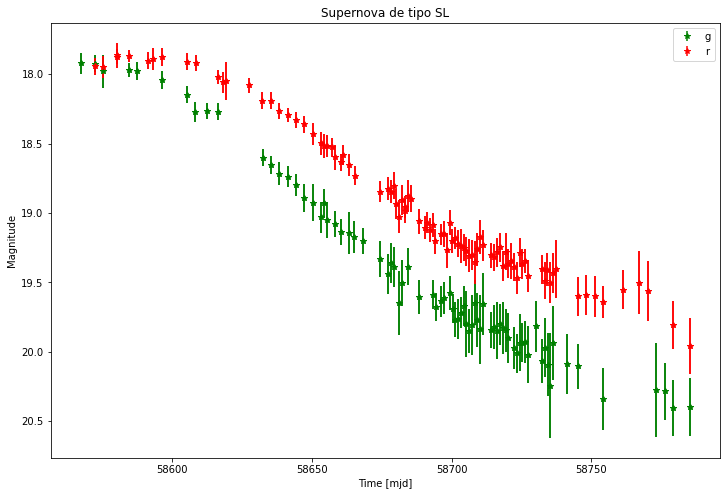

In [17]:
# GRAFICAMOS LA CURVA PARA LA SUPERNOVA DE TIPO SL
lc_g_SLSN = Curva_SLSN[Curva_SLSN.fid == 1]
lc_r_SLSN = Curva_SLSN[Curva_SLSN.fid == 2]
fig = plt.figure(figsize=(12, 8))
fig.set_facecolor('white')

plt.errorbar(lc_g_SLSN['mjd'], lc_g_SLSN['magpsf_corr'], yerr=lc_g_SLSN['sigmapsf_corr'], fmt='*g', label='g')
plt.errorbar(lc_r_SLSN['mjd'], lc_r_SLSN['magpsf_corr'], yerr=lc_r_SLSN['sigmapsf_corr'], fmt='*r', label='r')
plt.xlabel('Time [mjd]')
plt.ylabel('Magnitude')
plt.title('Supernova de tipo SL')
plt.legend()
plt.gca().invert_yaxis()

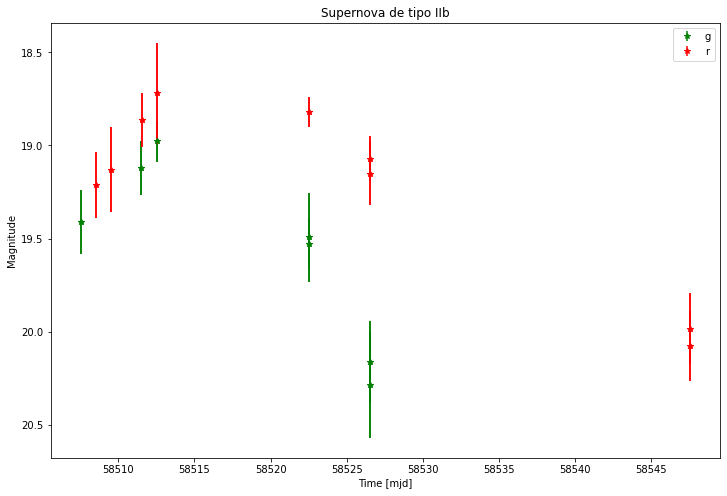

In [18]:
# GRAFICAMOS LA CURVA PARA LA SUPERNOVA DE TIPO IIb
lc_g_SNIIb = Curva_SNIIb[Curva_SNIIb.fid == 1]
lc_r_SNIIb = Curva_SNIIb[Curva_SNIIb.fid == 2]
fig = plt.figure(figsize=(12, 8))
fig.set_facecolor('white')

plt.errorbar(lc_g_SNIIb['mjd'], lc_g_SNIIb['magpsf_corr'], yerr=lc_g_SNIIb['sigmapsf_corr'], fmt='*g', label='g')
plt.errorbar(lc_r_SNIIb['mjd'], lc_r_SNIIb['magpsf_corr'], yerr=lc_r_SNIIb['sigmapsf_corr'], fmt='*r', label='r')
plt.xlabel('Time [mjd]')
plt.ylabel('Magnitude')
plt.title('Supernova de tipo IIb')
plt.legend()
plt.gca().invert_yaxis()

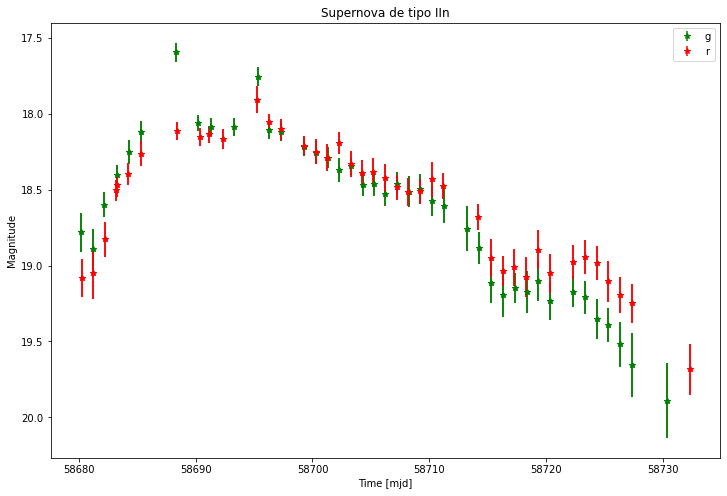

In [19]:
# GRAFICAMOS LA CURVA PARA LA SUPERNOVA DE TIPO IIn
lc_g_SNIIn = Curva_SNIIn[Curva_SNIIn.fid == 1]
lc_r_SNIIn = Curva_SNIIn[Curva_SNIIn.fid == 2]
fig = plt.figure(figsize=(12, 8))
fig.set_facecolor('white')

plt.errorbar(lc_g_SNIIn['mjd'], lc_g_SNIIn['magpsf_corr'], yerr=lc_g_SNIIn['sigmapsf_corr'], fmt='*g', label='g')
plt.errorbar(lc_r_SNIIn['mjd'], lc_r_SNIIn['magpsf_corr'], yerr=lc_r_SNIIn['sigmapsf_corr'], fmt='*r', label='r')
plt.xlabel('Time [mjd]')
plt.ylabel('Magnitude')
plt.title('Supernova de tipo IIn')
plt.legend()
plt.gca().invert_yaxis()

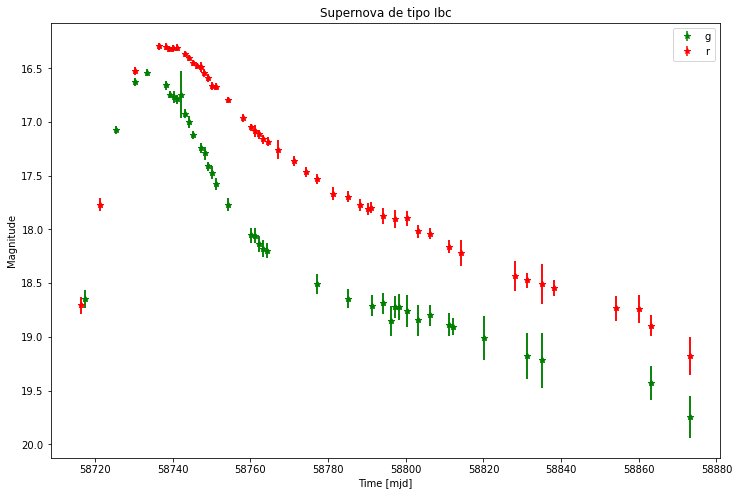

In [20]:
# GRAFICAMOS LA CURVA PARA LA SUPERNOVA DE TIPO Ibc
lc_g_SNIbc = Curva_SNIbc[Curva_SNIbc.fid == 1]
lc_r_SNIbc = Curva_SNIbc[Curva_SNIbc.fid == 2]
fig = plt.figure(figsize=(12, 8))
fig.set_facecolor('white')

plt.errorbar(lc_g_SNIbc['mjd'], lc_g_SNIbc['magpsf_corr'], yerr=lc_g_SNIbc['sigmapsf_corr'], fmt='*g', label='g')
plt.errorbar(lc_r_SNIbc['mjd'], lc_r_SNIbc['magpsf_corr'], yerr=lc_r_SNIbc['sigmapsf_corr'], fmt='*r', label='r')
plt.xlabel('Time [mjd]')
plt.ylabel('Magnitude')
plt.title('Supernova de tipo Ibc')
plt.legend()
plt.gca().invert_yaxis()

# Extracción de características preliminar

In [15]:
#----------------------------SupernovaeDetectionFeatureExtractor-------------------------------------------------------
# detections_df has missing columns: SupernovaeDetectionFeatureExtractor requires ('isdiffpos', 'magnitude', 'time', 'band')
#Le cambiamos los nombres a las columnas correspondientes pues este extractor necesita de estas columnas para funcionar
detections_df= Datos_Final.rename(columns={'magpsf':'magnitude','mjd':'time', 'fid':'band'})
feature_extractor = SupernovaeDetectionFeatureExtractor(bands=(1, 2))
features = feature_extractor.compute_features(detections = detections_df)
features

,delta_mag_fid_1,delta_mjd_fid_1,first_mag_1,mean_mag_1,min_mag_1,n_det_1,n_neg_1,n_pos_1,positive_fraction_1,delta_mag_fid_2,delta_mjd_fid_2,first_mag_2,mean_mag_2,min_mag_2,n_det_2,n_neg_2,n_pos_2,positive_fraction_2
oid,,,,,,,,,,,,,,,,,,
2,0.0,0.0,16.072975,16.072975,16.072975,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,17.708502,17.708502,17.708502,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.0,0.0,16.626165,16.626165,16.626165,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0,0.0,18.192377,18.192377,18.192377,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0,0.0,18.481302,18.481302,18.481302,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,19.317352,19.317352,19.317352,1.0,0.0,1.0,1.0
128714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,18.340456,18.340456,18.340456,1.0,0.0,1.0,1.0
128715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,18.389997,18.389997,18.389997,1.0,0.0,1.0,1.0


In [ ]:
#----------------------------IQREXTRACTOR------------------------------------------------------------------------------

detections_df3 = Datos_Final.rename(columns={'magpsf':'magnitude','mjd':'time', 'fid':'band'})
feature_extractor3 = IQRExtractor(bands=(1, 2))
features3 = feature_extractor3.compute_features(detections = detections_df3)

In [ ]:
df = features.join(features3)

In [22]:
df

,delta_mag_fid_1,delta_mjd_fid_1,first_mag_1,mean_mag_1,min_mag_1,n_det_1,n_neg_1,n_pos_1,positive_fraction_1,delta_mag_fid_2,delta_mjd_fid_2,first_mag_2,mean_mag_2,min_mag_2,n_det_2,n_neg_2,n_pos_2,positive_fraction_2,iqr_1,iqr_2
oid,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,16.072975,16.072975,16.072975,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,0.0,0.0,17.708502,17.708502,17.708502,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
6,0.0,0.0,16.626165,16.626165,16.626165,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
8,0.0,0.0,18.192377,18.192377,18.192377,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
9,0.0,0.0,18.481302,18.481302,18.481302,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,19.317352,19.317352,19.317352,1.0,0.0,1.0,1.0,NaN,0.0
128714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,18.340456,18.340456,18.340456,1.0,0.0,1.0,1.0,NaN,0.0
128715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,18.389997,18.389997,18.389997,1.0,0.0,1.0,1.0,NaN,0.0


In [ ]:
df = df.reset_index()

# Separación del conjunto en ENTRENAMIENTO y TEST: 
Dividiremos el conjunto en 70% para entrenamiento y 30% para test

In [ ]:
from sklearn.utils import shuffle

#Datos_Final.set_index("objectId", inplace = True)

#--------------------le agregamos la clase que le corresponde a cada registro---------------------------
df_con_target = pd.merge(df, dfcrossmatches[['oid','classALeRCE']], left_on='oid', right_on='oid')

#--------------------Mezclamos los datos de tal manera de poder tomar muestras representativas del conjunto-----------------
df_shuffle = shuffle(df_con_target)

#--------------------Eliminamos los NaN en caso de que aun queden -------------------------------------------------
df_shuffle = df_shuffle.dropna()

In [ ]:
df_shuffle.head()

In [ ]:
rows= df_shuffle.shape[0] 

# ENTRENAMIENTO DESDE 0 A int(rows*0.7)
train = df_shuffle.iloc[0:int(rows*0.7)]

# TEST DESDE int(rows*0.7) HASTA EL FINAL
test = df_shuffle.iloc[int(rows*0.7):rows]

In [ ]:
target_entrenamiento = np.array(train['classALeRCE'])


In [ ]:
train_sin_target = train.iloc[:,1:20]
print(train_sin_target.head())
data = train_sin_target.to_numpy()
print(data.shape)

# Matriz de covarianza: Veamos la matriz de correlación, para ver que tan relacionados estan los datos



Nos permite visualizar de forma gráfica que tan correlacionados estan las caracteristicas extraidas por los extractores.

In [ ]:
import seaborn as sns

# taking all rows but only 6 columns
df_small = df.iloc[:,1:20]

correlation_mat = df_small.corr()

plt.figure(figsize=(12,12))
sns.heatmap(correlation_mat, annot = True)

plt.show()

# Analisis de componentes principales PCA: algoritmo que nos permite reducir la dimensionalidad de los datos.

In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X = np.array(Datos_Final[['isdiffpos','magpsf','mjd','magpsf_corr','sigmapsf','sigmapsf_corr','fid','sigmapsf']])
# 'objectId','classALeRCE'
y = np.array(Datos_Final['classALeRCE'])
# Standardizing the features
x = StandardScaler().fit_transform(X)

pca = PCA()
arreglo = pca.fit_transform(x)
df = pd.DataFrame(arreglo)

fig = plt.figure()
plt.title('PCA de los datos')
fig.patch.set_facecolor('white')
plt.scatter(df[0], df[1],s=100,alpha=0.5)
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)

# Clasificación preliminar, utilizando arboles de decisión:

In [ ]:
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

In [ ]:
classifier = DecisionTreeClassifier()

#-----------------------ENTRENAMIENTO-----------------------------------------
classifier.fit(data,target_entrenamiento)


#------------------SE PRUEBA EL CLASIFICADOR----------------------------------
# predict new data:
test_sin_target = test.iloc[:,1:20]
#pues solo usaremos el target para comprobar la eficacia de la predicción
newdata = test_sin_target.to_numpy()
pred_labels = classifier.predict(newdata)


pred_labels_df = pd.DataFrame(pred_labels,columns=['pred_labels']) 
pred_labels_df.index = list(test["oid"])
pred_labels_df = pred_labels_df.reset_index()
pred_labels_df_n  = pred_labels_df.rename(columns={'index':'oid'})
comparacion_resultados = pd.merge(pred_labels_df_n, dfcrossmatches[['oid','classALeRCE']], left_on='oid', right_on='oid')
comparacion_resultados

# RESULTADOS CLASIFICACIÓN PRELIMINAR

In [ ]:
iguales = sum([comparacion_resultados['pred_labels']==comparacion_resultados['classALeRCE']])
total = iguales.shape[0] 
print('N° de aciertos usando arboles de decisión como clasificador:')
print( f'N° de aciertos: {iguales.sum()}, N° de errores: {total-iguales.sum()}')
print(f'Porcentaje de clasificaciones correctas: {"{:.2f}".format((iguales.sum()/total)*100)}% \nPorcentaje de clasificaciones incorrectas: {"{:.2f}".format(((total-iguales.sum())/total)*100)}%')

# Clasificación preliminar, utilizando arboles de decisión y un previo PCA() a los datos:
Ejemplo uso Pca antes de la clasificacion

In [ ]:
# initiate PCA and classifier
pca = PCA()
classifier_para_pca = DecisionTreeClassifier()


# transform / fit
X_transformed = pca.fit_transform(data)
classifier_para_pca.fit(X_transformed, target_entrenamiento)


In [ ]:
#-----------------PCA DE LAS FEATURES/CARACTERISTICAS-----------------------------
graficar_pca = pd.DataFrame(X_transformed)
fig1 = plt.figure()
plt.title('PCA')
fig1.patch.set_facecolor('white')
plt.scatter(graficar_pca[0], graficar_pca[1],s=100,alpha=0.5)
plt.title("PCA de las features")
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)



In [ ]:
# transform new data using already fitted pca
# (don't re-fit the pca)
newdata_transformed = pca.transform(newdata)

# predict labels using the trained classifier

pred_labels_pca = classifier_para_pca.predict(newdata_transformed)

In [ ]:
pred_labels_df_pca = pd.DataFrame(pred_labels_pca,columns=['pred_labels']) 

In [ ]:
pred_labels_df_pca.index = list(test["oid"])
pred_labels_df_pca = pred_labels_df_pca.reset_index()
pred_labels_df_pca_n  = pred_labels_df_pca.rename(columns={'index':'oid'})
comparacion_resultados_pca = pd.merge(pred_labels_df_pca_n, dfcrossmatches[['oid','classALeRCE']], left_on='oid', right_on='oid')
comparacion_resultados_pca

# Resultados clasificación preliminar usando previamente PCA()


In [ ]:
iguales_pca = sum([comparacion_resultados_pca['pred_labels']==comparacion_resultados_pca['classALeRCE']])
total_usando_pca = iguales_pca.shape[0] 
print('N° de aciertos usando arboles de decisión como clasificador:')
print( f'N° de aciertos: {iguales_pca.sum()}, N° de errores: {total_usando_pca-iguales_pca.sum()}')
print(f'Porcentaje de clasificaciones correctas: {"{:.2f}".format((iguales_pca.sum()/total)*100)}% \nPorcentaje de clasificaciones incorrectas: {"{:.2f}".format(((total_usando_pca-iguales_pca.sum())/total)*100)}%')